<a href="https://colab.research.google.com/github/SidharthBhakth/Speech-Denoising/blob/main/05_Speech_Denoising_using_RNN(GRU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Speech Denoising using RNN(GRU)**

In [ ]:
!pip install soundfile

In [ ]:
# Import libraries
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_context('poster')

import librosa
import soundfile as sf
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set directories
wdir = '/content/drive/My Drive/E533_DLS/timit-homework'
tr_dir = wdir + '/tr/'
te_dir = wdir + '/te/'
v_dir = wdir + '/v/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check if GPU is available
print(torch.cuda.is_available())

# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [ ]:
# Create a list of all files

# Train
tr_noise = [ tr_dir + 'trn' + str(i).zfill(4) + '.wav' for i in range(0, 1200) ]
tr_speech = [ tr_dir + 'trs' + str(i).zfill(4) + '.wav' for i in range(0, 1200) ]
tr_noisy_speech = [ tr_dir + 'trx' + str(i).zfill(4) + '.wav' for i in range(0, 1200) ]

# Validation
val_noise = [ v_dir + 'vn' + str(i).zfill(4) + '.wav' for i in range(0, 1200) ]
val_speech = [ v_dir + 'vs' + str(i).zfill(4) + '.wav' for i in range(0, 1200) ]
val_noisy_speech = [ v_dir + 'vx' + str(i).zfill(4) + '.wav' for i in range(0, 1200) ]

# Test
te_noisy_speech = [ te_dir + 'tex' + str(i).zfill(4) + '.wav' for i in range(0, 400) ]

In [ ]:
def create_spectrogram(files_list):
    
    S = []
    signal_length = []


    for file in files_list:
        signal, _ = librosa.load(file, sr=None)
        spec = librosa.stft(signal, n_fft=1024, hop_length=512)
        spec = torch.FloatTensor(np.abs(spec).T)
        S.append(spec)
        signal_length.append(len(signal))
    
    max_length = max([ len(tensor) for tensor in S ])

    for i, tensor in enumerate(S):
        if len(tensor) < max_length:
            S[i] = torch.cat((tensor, torch.zeros(max_length - len(tensor), tensor.shape[1])))

    return torch.stack(S), torch.Tensor(signal_length)

In [ ]:
# N_tr, _ = create_spectrogram(tr_noise)
# S_tr, _ = create_spectrogram(tr_speech)
# X_tr, _ = create_spectrogram(tr_noisy_speech)

# torch.save(N_tr, tr_dir + 'noise_tensor.pt')
# torch.save(S_tr, tr_dir + 'speech_tensor.pt')
# torch.save(X_tr, tr_dir + 'noisy_speech_tensor.pt')

In [ ]:
N_tr = torch.load(tr_dir + 'noise_tensor.pt', map_location='cpu')
S_tr = torch.load(tr_dir + 'speech_tensor.pt', map_location='cpu')
X_tr = torch.load(tr_dir + 'noisy_speech_tensor.pt', map_location='cpu')

print(N_tr.shape)
print(S_tr.shape)
print(X_tr.shape)

# Create IBM matrix
M_tr = 1. * (S_tr > N_tr)

print(M_tr.shape)

train_loader = DataLoader(TensorDataset(X_tr, S_tr, M_tr), batch_size = 20, shuffle = True)

torch.Size([1200, 178, 513])
torch.Size([1200, 178, 513])
torch.Size([1200, 178, 513])
torch.Size([1200, 178, 513])


In [ ]:
# N_val, _ = create_spectrogram(val_noise)
# S_val, _ = create_spectrogram(val_speech)
# X_val, _ = create_spectrogram(val_noisy_speech)

# torch.save(N_val, v_dir + 'noise_tensor.pt')
# torch.save(S_val, v_dir + 'speech_tensor.pt')
# torch.save(X_val, v_dir + 'noisy_speech_tensor.pt')

In [ ]:
N_val = torch.load(v_dir + 'noise_tensor.pt', map_location='cpu')
S_val = torch.load(v_dir + 'speech_tensor.pt', map_location='cpu')
X_val = torch.load(v_dir + 'noisy_speech_tensor.pt', map_location='cpu')

print(N_val.shape)
print(S_val.shape)
print(X_val.shape)

# Create IBM matrix
M_val = 1. * (S_val > N_val)

print(M_val.shape)

val_loader = DataLoader(TensorDataset(X_val, S_val, M_val), batch_size = 20, shuffle = True)

torch.Size([1200, 178, 513])
torch.Size([1200, 178, 513])
torch.Size([1200, 178, 513])
torch.Size([1200, 178, 513])


In [ ]:
# X_te, X_len = create_spectrogram(te_noisy_speech)
# test = TensorDataset(X_te, X_len)

# torch.save(test, te_dir + 'noisy_speech_tensor.pt')

In [ ]:
test = torch.load(te_dir + 'noisy_speech_tensor.pt')

test_loader = DataLoader(test, batch_size = 1, shuffle = False)

In [ ]:
class DenoisingRNN(nn.Module):
    def __init__(self, input_size = 513, hidden_size = 513, num_layers = 2):
        super(DenoisingRNN, self).__init__()

        # Define parameters
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first = True, dropout = 0.2)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, _ = self.rnn(x, hidden.to(device))

        return out
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden


# Instantiate neural network class
NN = DenoisingRNN()
NN.to(device)

DenoisingRNN(
  (rnn): GRU(513, 513, num_layers=2, batch_first=True, dropout=0.2)
)

In [ ]:
def calculate_SNR(clean, denoised):
    
    numerator = torch.sum(torch.square(clean))
    denominator = torch.sum(torch.square(clean - denoised))
    
    return 10 * torch.log10(numerator/denominator)

In [ ]:
def train(model = NN, lr=0.001, n_epochs = 100):

    # hyperparameters
    criterion = nn.MSELoss()
    optimizer = optim.Adam(NN.parameters(), lr)

    train_loss = []
    # train_SNR = []
    val_loss = []
    val_SNR = []

    for epoch in range(1, n_epochs+1):

        running_loss = 0
        running_SNR = 0

        # Train
        NN.train()
        for X_tr, _, M_tr in train_loader:
            X_tr, M_tr = X_tr.to(device), M_tr.to(device)                       # Transfer to GPU
            optimizer.zero_grad()                                               # Set the parameter gradients to zero
            M_hat = NN(X_tr)                                                    # Forward pass to predict IBM
            loss = criterion(M_hat, M_tr)                                       # Compute loss on train data
            running_loss += loss.item()
            loss.backward()                                                     # Backpropagation
            optimizer.step()                                                    # Optimization
        
        # Keep track of train loss and SNR for each epoch
        train_loss.append(running_loss/len(train_loader))
        
        # Validate
        NN.eval()
        with torch.no_grad():
            running_loss = 0
            running_SNR = 0
            for X_val, S_val, M_val in val_loader:
                X_val, M_val = X_val.to(device), M_val.to(device)               # Transfer to GPU
                M_hat = NN(X_val)                                               # Forward pass to predict IBM
                loss = criterion(M_hat, M_val)                                  # Compute loss on validation data
                running_loss += loss.item()
                S_hat = M_hat * X_val                                           # Denoise signal using learned IBM
                SNR = calculate_SNR(S_val, S_hat.cpu())                         # Calculate SNR
                running_SNR += SNR

        # Keep track of validation loss and SNR for each epoch
        val_loss.append(running_loss/len(val_loader))
        val_SNR.append(running_SNR/len(val_loader))

        if epoch%10 == 0:
            print(f"Epoch {epoch:3} | train loss: {train_loss[-1]:.4f}, validation loss: {val_loss[-1]:4f}, validation SNR: {val_SNR[-1]:>2.4f} dB")
    
    return train_loss, val_loss, val_SNR

In [ ]:
train_loss, val_loss, val_SNR = train()

Epoch  10 | train loss: 0.0800, validation loss: 0.079567, validation SNR: 9.7715 dB
Epoch  20 | train loss: 0.0681, validation loss: 0.073031, validation SNR: 10.2948 dB
Epoch  30 | train loss: 0.0627, validation loss: 0.071485, validation SNR: 10.5790 dB
Epoch  40 | train loss: 0.0598, validation loss: 0.070381, validation SNR: 10.8782 dB
Epoch  50 | train loss: 0.0574, validation loss: 0.071864, validation SNR: 10.8293 dB
Epoch  60 | train loss: 0.0555, validation loss: 0.071307, validation SNR: 11.0160 dB
Epoch  70 | train loss: 0.0539, validation loss: 0.070263, validation SNR: 11.2479 dB
Epoch  80 | train loss: 0.0531, validation loss: 0.070273, validation SNR: 11.1446 dB
Epoch  90 | train loss: 0.0522, validation loss: 0.069879, validation SNR: 11.1871 dB
Epoch 100 | train loss: 0.0516, validation loss: 0.070052, validation SNR: 11.2199 dB


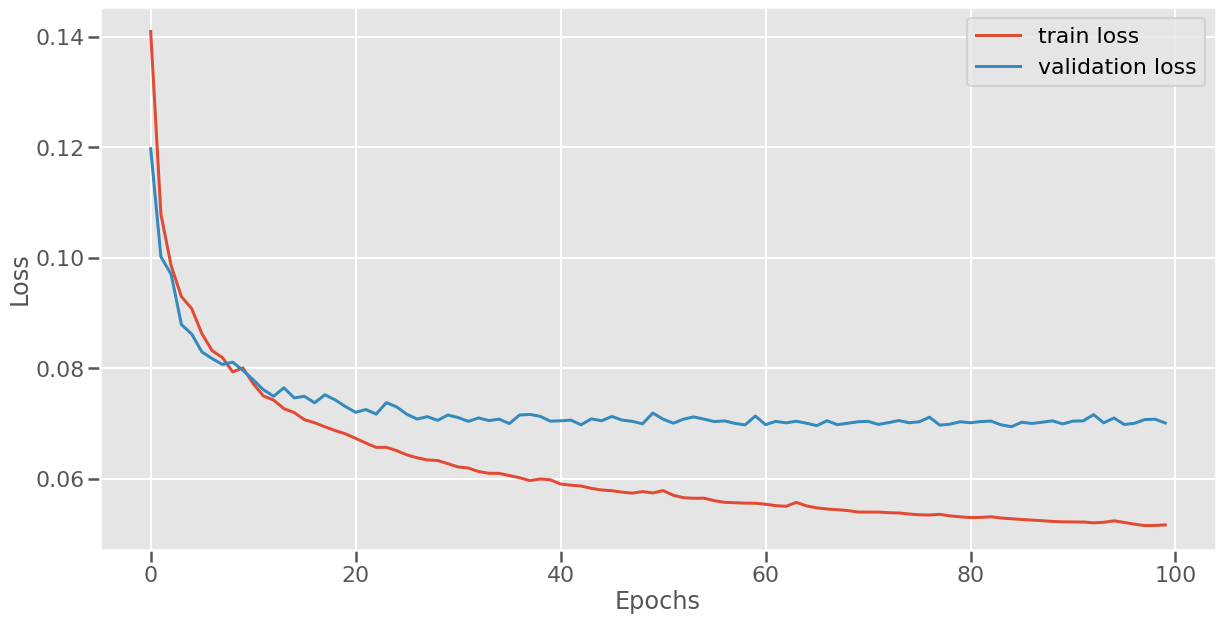

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

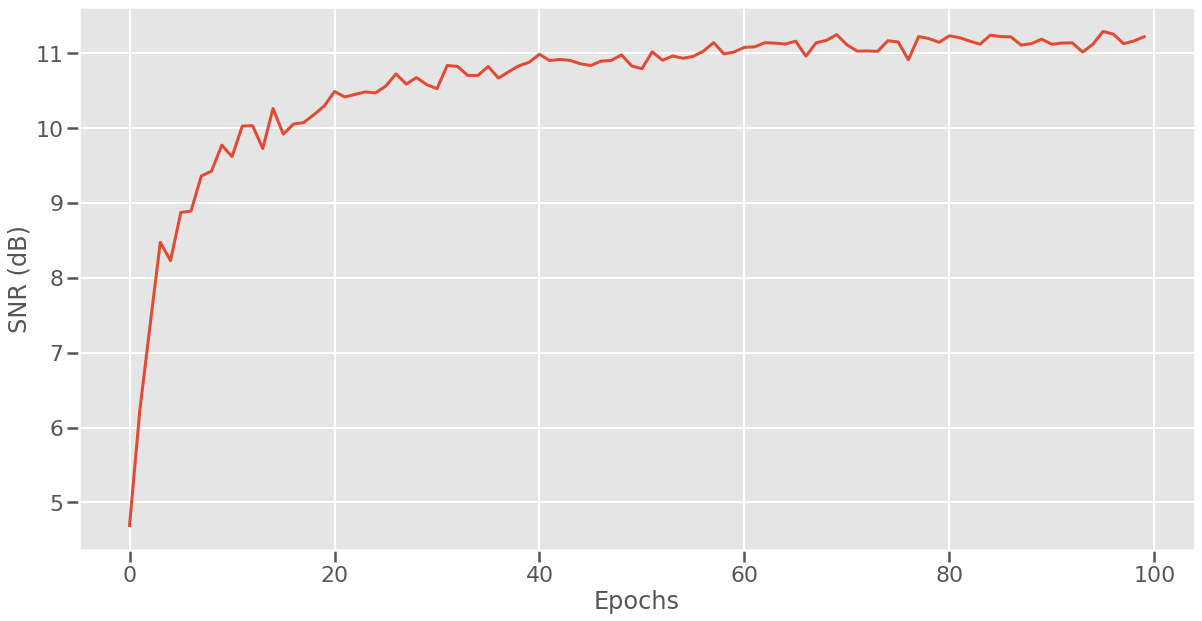

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(val_SNR)
plt.ylabel('SNR (dB)')
plt.xlabel('Epochs')
plt.show()

## Testing

In [ ]:
out_dir = '/content/drive/My Drive/E533_DLS/timit-homework/te/denoised/'

with torch.no_grad():
    for i, (X_te, X_len) in enumerate(test_loader):
        X_te = X_te.to(device)                                                  # Transfer to GPU
        M_hat = NN(X_te)                                                        # Forward pass to predict IBM
        S_hat = M_hat * X_te                                                    # Denoise signal using learned IBM

        S_hat_t = librosa.istft(S_hat.cpu().numpy().T, hop_length = 512, length = int(X_len.item()))
        filename = out_dir + 'tex' + str(i).zfill(4) + '_denoised.wav'
        sf.write(filename, S_hat_t, samplerate = 16000)

In [ ]:
# Reconstruct 5 randomly sampled audio files
rand_idx = np.random.randint(399, size=5)

for i in rand_idx:
    print("Noisy speech:")
    display(Audio(te_dir + 'tex' + str(i).zfill(4) + '.wav'))
    print("Denoised speech:")
    display(Audio(out_dir + 'tex' + str(i).zfill(4) + '_denoised.wav'))

Noisy speech:


Denoised speech:


Noisy speech:


Denoised speech:


Noisy speech:


Denoised speech:


Noisy speech:


Denoised speech:


Noisy speech:


Denoised speech:
